In [14]:
import numpy as np
import multiprocess as mp
import statsmodels.stats.api as sms
from math import ceil
from tqdm import tqdm

In [15]:
from src.bootstrap import bootstrap_ci
from src.perm_test import search
from src.utils import partition

---

In [16]:
# https://www.statsmodels.org/dev/generated/statsmodels.stats.weightstats.CompareMeans.tconfint_diff.html
def tconfint(alpha, x1, x2, pooled=True, alternative="two-sided"):
    cm = sms.CompareMeans(sms.DescrStatsW(x1), sms.DescrStatsW(x2))
    return cm.tconfint_diff(alpha, alternative, usevar="pooled" if pooled else "unequal")

In [4]:
def passToThread(start_idx, end_idx, two_sided=True, pooled=True, method="permutation", alpha=0.05):

    def invert_test(idx, alternative, method="permutation"):
        x1, x2 = x1s[idx], x2s[idx]
        if method == "t":
            lower, upper = tconfint(alpha, x1, x2, pooled, alternative)
            return lower, upper
        
        t99 = tconfint(0.001, x1, x2, pooled, alternative)
        t90 = tconfint(0.20, x1, x2, pooled, alternative)        
        lower, upper = -np.inf, np.inf
        if alternative != "smaller":
            lower = search(x1, x2, partitions, t99[0], t90[0], pooled=pooled, alternative=alternative)
        if alternative != "larger":
            upper = search(x1, x2, partitions, t90[1], t99[1], pooled=pooled, alternative=alternative)
        return lower, upper

    n_captured = n_error = 0
    for i in range(start_idx, end_idx):
        try:
            if two_sided:
                lower, upper = invert_test(i, "two-sided", method)
            else:
                lower1, upper1 = invert_test(i, "smaller", method)
                lower2, upper2 = invert_test(i, "larger", method)
                lower, upper = max(lower1, lower2), min(upper1, upper2)
        except AssertionError:
            n_error += 1
            continue
        n_captured += (lower <= delta_true) * (delta_true <= upper)
    return n_captured, n_error

In [5]:
def simulate(coverages, i, two_sided=True, pooled=True, method="permutation"):
    pool = mp.Pool(mp.cpu_count())
    results = pool.starmap(passToThread, [(i * batch_size, min(total, i * (batch_size+1)),\
                                           two_sided, pooled, method) for i in range(n_batches)])
    pool.close()
    pool.join()
    results = np.array(results).sum(axis=0)
    if not results[1]:
        coverages[i].append(results[0] / total)

---

smaller sample sizes, show example ouptuts for each function

In [17]:
n1, n2 = 5, 5
partitions = partition(n1, n2)
partitions

array([[0, 1, 2, ..., 7, 8, 9],
       [0, 1, 2, ..., 7, 8, 9],
       [0, 1, 2, ..., 7, 8, 9],
       ...,
       [4, 5, 7, ..., 2, 3, 6],
       [4, 6, 7, ..., 2, 3, 5],
       [5, 6, 7, ..., 2, 3, 4]])

In [18]:
partitions.shape

(252, 10)

In [19]:
np.random.seed(123)
gammas = np.random.randint(1, 11, (3,2,2))

---

In [13]:
total = 100  # num. samples per gamma
batch_size = mp.cpu_count()
n_batches = ceil(total/batch_size)

In [18]:
def get_coverages(coverages, g):
    global x1s, x2s, delta_true
    
    np.random.seed(123)
    # global variables
    x1s = np.random.gamma(g[0,0], g[0,1], (total, n1))
    x2s = np.random.gamma(g[1,0], g[1,1], (total, n2))
    delta_true = (g[0,0] * g[0,1]) - (g[1,0]*g[1,1])  # true mean difference
    
    i = 0
    processes = []
    for two_sided in [True, False]:
        for pooled in [True, False]:
            for method in ["permutation", "t"]:
                # print(f"two_sided: {two_sided}, pooled: {pooled}, method: {method}")
                #sub_l = manager.list(coverages[i])
                #sub_l.append(simulate(two_sided, pooled, method))
                #coverages[i] = sub_l
                p = mp.Process(target=simulate, args=(coverages, i, two_sided, pooled, method))
                processes.append(p)
                p.start()
                i += 1
    for p in processes:
        p.join()

In [19]:
%%time

manager = mp.Manager()
coverages = manager.list([manager.list() for _ in range(8)])

processes = []
for g in gammas:
    p = mp.Process(target=get_coverages, args=(coverages, g))
    processes.append(p)
    p.start()

for p in processes:
    p.join()

Process Process-9:4:
Process Process-10:2:
Process Process-10:3:
Process Process-8:1:
Process Process-8:5:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
Process Process-9:2:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/multiprocess/managers.py", line 801, in _callmethod
    conn = self._tls.connection
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/multiprocess/managers.py", line 801, in _callmethod
    conn = self._tls.connection
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/multiprocess/managers.py", line 801, in _callmethod
    conn = self._tls.connection
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/multiprocess/managers.py", line 801, in _callmethod
    conn = self._tls.connection
Traceback

  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/multiprocess/connection.py", line 638, in SocketClient
    s.connect(address)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/multiprocess/connection.py", line 510, in Client
    c = SocketClient(address)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/multiprocess/connection.py", line 638, in SocketClient
    s.connect(address)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/multiprocess/connection.py", line 638, in SocketClient
    s.connect(address)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/multiprocess/connection.py", line 510, in Client
    c = SocketClient(address)
  File "/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/multiprocess/connection.py", line 510, in Client
    c = SocketClient(address)
C

CPU times: user 34 ms, sys: 41.8 ms, total: 75.8 ms
Wall time: 876 ms


In [20]:
for coverage in coverages:
    print(list(coverage))

[0.69, 0.69]
[0.68]
[0.7]
[0.69, 0.68]
[0.66, 0.67]
[0.67, 0.65, 0.64]
[0.7, 0.66, 0.67]
[0.65, 0.67, 0.66]


In [21]:
import matplotlib.pyplot as plt
%matplotlib inline

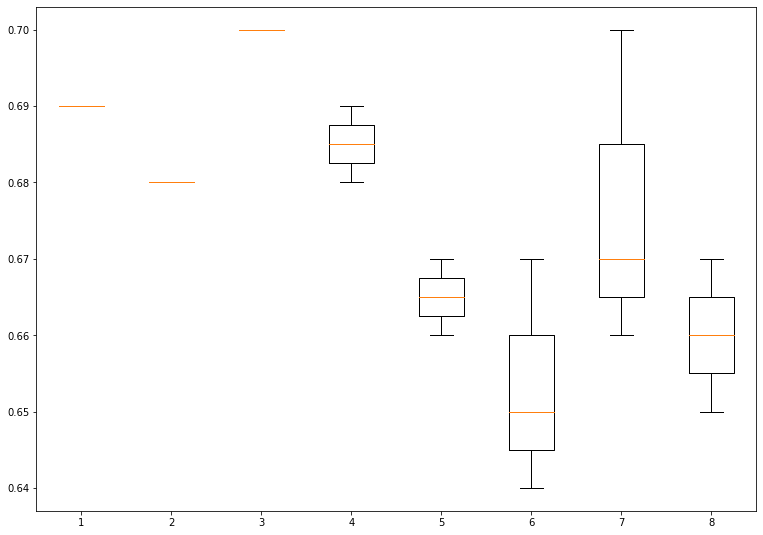

In [22]:
coverages = [list(sublist) for sublist in coverages]  # convert to regular list of lists
fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(coverages)

In [1]:
from src.perm_test import ttest_ind

In [4]:
A = np.array([[1, 2], [3, 4]])
B = np.array([[2, 3], [5, 6]])

In [5]:
ttest_ind

<function src.perm_test.ttest_ind(x1s, x2s, n1, n2, pooled=True)>

In [6]:
ttest_ind(A, B, 2, 2, True)

array([-1.41421356, -2.82842712])

In [13]:
A = np.random.random((1000,12))
B = np.random.random((1000, 8))
%time ttest_ind(A, B, 12, 8, True)

CPU times: user 1.03 ms, sys: 1.31 ms, total: 2.34 ms
Wall time: 1.16 ms


array([-2.98595345e+00,  1.01757469e+00, -6.11059738e-01, -1.63868419e+00,
       -2.02239902e+00,  3.91807562e-02, -7.44007464e-01,  4.86062053e-01,
       -1.31914883e+00, -6.90098677e-01, -1.89421446e-01,  7.61164929e-01,
       -6.28359603e-01, -1.06873173e+00, -1.06261650e+00, -3.16403142e-01,
        1.13283249e+00, -5.59069347e-01, -1.63116083e+00,  5.89170792e-01,
        2.25310133e+00,  1.19498636e+00,  1.96115013e-01, -2.10509704e-01,
        7.22006002e-01, -3.82774009e-01,  3.01438907e-01, -6.89647686e-02,
       -9.24429786e-01, -9.64666237e-01,  1.95081266e+00,  7.32980711e-01,
       -1.68958327e+00, -1.47488010e+00, -1.31840903e+00,  1.01778333e+00,
       -2.17433996e+00,  1.11702183e+00,  2.51980450e-01,  1.03011283e+00,
       -8.71894396e-01,  4.89197343e-01,  4.32362387e-01,  2.26528491e+00,
        1.06647435e+00,  1.67825898e-01, -8.25457529e-01, -4.67533954e-02,
        1.09638317e-01,  2.50687805e-01,  8.92731320e-01,  2.06133026e-01,
        1.18660157e+00,  